### Detecção de fraude em transações de cartão de crédito

🎯 Objetivos:

Nesse projeto, utilizarei a base da dados do Kaggle: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) para por em prática alguns conceitos importantes de Machine Learning, como:

🔎 Redução de dimensionalidade (PCA)

🔎 Como lidar com dados desbalanceados?
  - Undersampling
  - Oversampling (SMOTE)
  - Downsample and Upweight
  - Boas práticas

🔎 Detecção de outliers

🔎 Processamento: Scalers

🔎 Remoção de outliers: quando é uma boa ideia?

🔎 Classificadores: Regressão logística e Random Forest

🔎 Métricas de avaliação
  - ROC
  - Precisão, acurácia, Recall e F1-Score
  - Matriz de confusão



A ideia é, basicamente, construir um modelo que seja capaz de identificar transações que são legítimas e transações que são fraudulentas.

#### 📚 Importando as bibliotecas necessárias

In [ ]:
# Processamento
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD

# Classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Utilidades
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
plt.style.use('ggplot')
sns.set_palette('pastel')
sns.set_style('whitegrid', {'axes.spines.left': True,
                            'axes.spines.bottom': True,
                            'axes.spines.right': True,
                            'axes.spines.top': True})

#### 🔁 Conectando o Google Colab ao Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 🎲 Importando os dados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projetos ML/Detecção de fraude/creditcard.csv')

#### 👀 Dando uma olhada na estrutura geral dos dados

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As colunas de V1 até V28 foram passadas por uma transformação de redução de dimensionalidade (PCA) para que os dados fossem "anonimizadas". As informações que envolvem transações de cartão de crédito são muito sensíveis e por isso tiveram de ser transformadas para serem disponibilizadas.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.isnull().sum().max()

0

In [ ]:
print('Quantidade de observações que não são fraudes:', df['Class'].value_counts()[0])
print('Quantidade de observações que são fraudes', df['Class'].value_counts()[1])

Quantidade de observações que não são fraudes: 284315
Quantidade de observações que são fraudes 492


In [ ]:
print('Porcentagem de observações que não são fraudes:', df['Class'].value_counts()[0] / df.shape[0])
print('Porcentagem de observações que são fraudes', df['Class'].value_counts()[1] / df.shape[0])

Porcentagem de observações que não são fraudes: 0.9982725143693799
Porcentagem de observações que são fraudes 0.001727485630620034


Text(0.5, 1.0, 'Distribuição da classe \n (0: Legítima | 1: Fraude)')

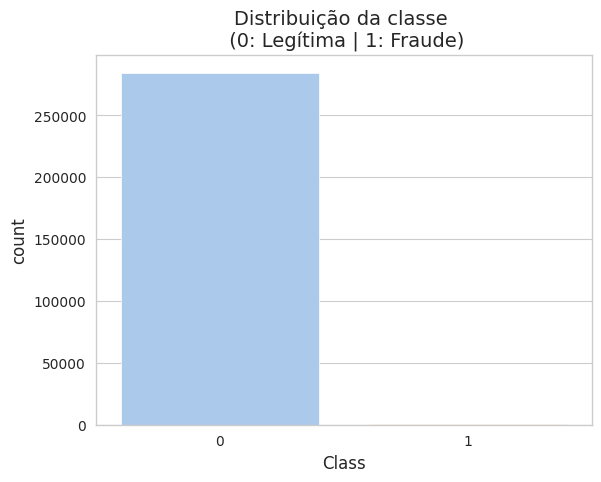

In [ ]:
sns.countplot(x='Class', data=df)
plt.title('Distribuição da classe \n (0: Legítima | 1: Fraude)', fontsize=14)

Podemos enxergar que o nosso dataset é MUITOO desbalanceado! Isso significa que se treinarmos o nosso modelo com os dados da maneira que estão, ele não conseguirá aprender os padrões que envolvem a classe subrepresentada.

**Quais são as boas práticas para lidar com um dataset desbalanceado?**


1. Avaliar as métricas corretas: Métricas de avaliação de modelo como acurácia podem ser enganosas em datasets desbalanceados, já que mesmo um modelo que sempre prediz a classe majoritária pode ter uma alta acurácia. Portanto, é importante utilizar outras métricas como precisão, recall, f1-score e auc-roc que levam em consideração o desbalanceamento das classes.

2. Utilizar técnicas de reamostragem: Técnicas de reamostragem como oversampling e undersampling podem ajudar a equilibrar as distribuições das classes. Oversampling envolve a criação de novas amostras para a classe minoritária, como o SMOTE (Synthetic Minority Over-sampling Technique), que cria novas amostras para a classe minoritária com base nas amostras existentes. Enquanto undersampling envolve a remoção de amostras da classe majoritária.

3. Utilizar validação cruzada estratificada: Quando dividimos o dataset em conjunto de treinamento e teste, é importante garantir que as proporções das classes sejam mantidas em ambas as partições. A validação cruzada estratificada é uma técnica que ajuda a garantir isso, dividindo o dataset em k-folds de forma que as proporções das classes sejam mantidas em cada fold.

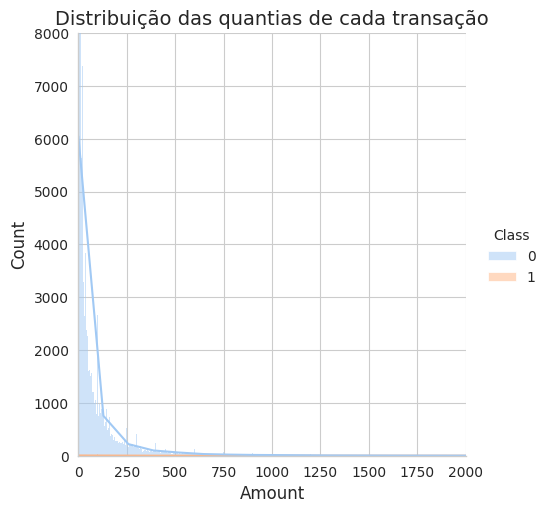

In [ ]:
sns.displot(data=df, x ='Amount', kde=True, hue='Class')
plt.title('Distribuição das quantias de cada transação', fontsize=14)
plt.xlim([0, 2000])
plt.ylim([0, 8000])

plt.show()

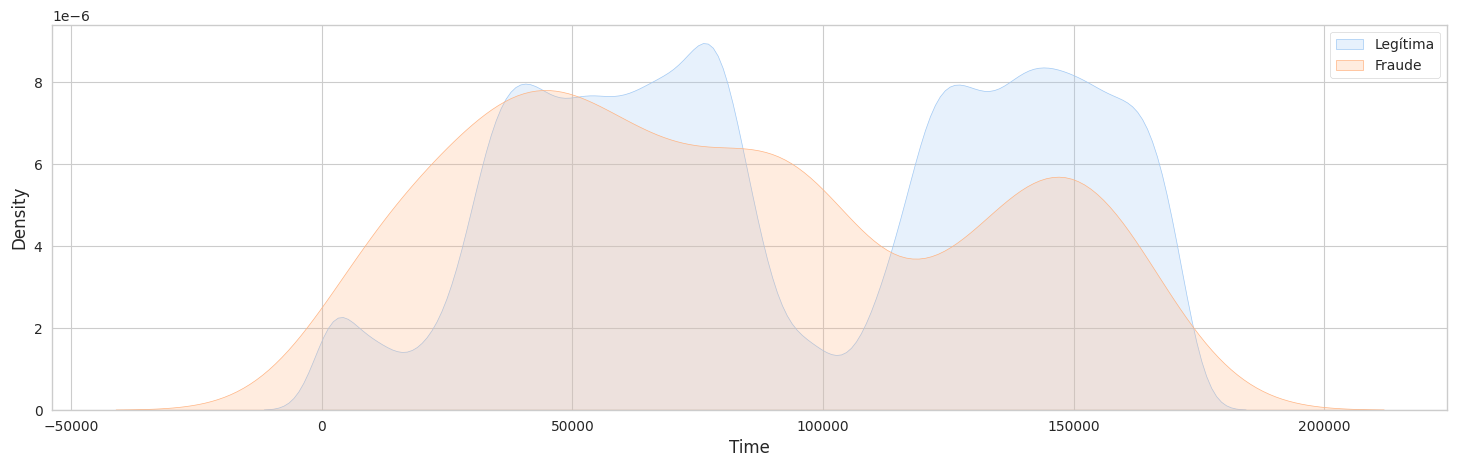

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

sns.kdeplot(df.query('Class==0').Time, ax=ax, shade=True, label='Legítima')
sns.kdeplot(df.query('Class==1').Time, ax=ax, shade=True, label='Fraude')

plt.legend()
plt.show()

In [ ]:
df.query('Class==0').Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
df.query('Class==1').Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

#### ⚙️ Pré-processamento dos dados

**A maioria das variáveis passaram pelo processo de redução de dimensionalidade por causa de questões de segurança e privacidade.**

**O que isso quer dizer?**


---


PCA (Principal Component Analysis) é uma técnica de análise multivariada que é usada para reduzir a dimensionalidade de conjuntos de dados complexos. Ele trabalha transformando um conjunto de variáveis correlacionadas em um conjunto menor de variáveis não correlacionadas (chamadas de componentes principais), mantendo a maior quantidade possível de variação nos dados.

Ao aplicar PCA a um conjunto de dados, o algoritmo identifica as principais direções ao longo das quais os dados variam, ou seja, as componentes principais. Cada componente principal é uma combinação linear das variáveis originais e é escolhida de forma a maximizar a variação dos dados.

Quando aplicamos PCA aos dados, é comum realizar a normalização dos dados, por meio de um "scaler", para garantir que todas as variáveis tenham a mesma importância e escala, evitando que as variáveis com maiores escalas dominem as outras durante o processo de análise.

**O que fazer com as variáveis que não passaram pelo PCA?**

Dado que a maioria das nossas variáveis passaram por uma transformação de escala e sabendo que alguns modelos performam melhor quando todas as variáveis estão em escalas próximas, vamos transformar também as colunas "Time" e "Amount" usando o Robust Scaler, que é melhor para lidar com outliers.

Ao usar o Robust Scaler, os dados são transformados de forma que a mediana da variável seja zero e o IQR seja igual a um. Isso garante que o scaler seja robusto a outliers e que as escalas das variáveis sejam comparáveis.

In [ ]:
rob_scaler = RobustScaler()

In [ ]:
df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

**Lidando com o dataset desbalanceado**

O primeiro problema que conseguimos enxergar nos dados através das primeiras análises foi que o nosso dataset é super desbalanceado. Isso faz sentido se pararmos pra pensar no problema de negócio que estamos tentando resolver. É razoável que a proporção de transações fraudulentas seja realmente bem menor em comparação a transações legítimas. Sabemos que não é uma boa prática treinar o modelo com essa distribuição, mas como lidar com esse problema?

Existem algumas técnicas que podem nos ajudar a resolver isso, as duas principais envolvem mudar a nossa mostra de dados (ou fazer o que chamamos de Resampling), e podem ser divididas entre métodos de Undersamplinhg, que envolve diminuir a quantidade da classe majoritária até que haja uma proporção satisfatória, e métodos de Oversampling, que envolvem aumentar a quantidade da classe minoritária através da criação de dados sintéticos.

Vamos testar ambas as abordagens e comparar seus resultados!

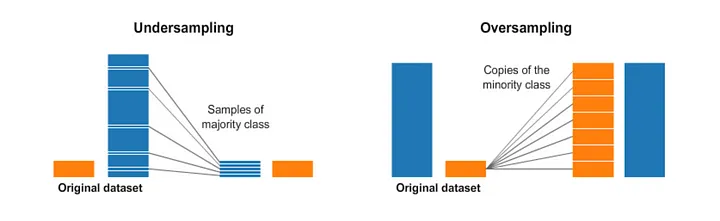

**Antes de testarmos essas abordagens, queremos evitar o erro comum de aplicar essas técnicas de transformação em todo o nosso dataset e depois separar entre treino e teste. Por que não devemos fazer isso? Aqui vão alguns motivos:**

- Representatividade do conjunto de teste: O conjunto de teste deve ser representativo da distribuição do mundo real. Se o conjunto de teste também for transformado, podemos enxergar resultados falsamente otimistas ou pessimistas do modelo.

- Data Leakage: Quando aplicamos técnicas de reamostragem em todo o conjunto de dados, podemos introduzir vazamento de dados (data leakage) no modelo. Isso ocorre porque informações do conjunto de teste podem ser utilizadas para balancear o conjunto de treinamento, o que pode levar a uma avaliação otimista do modelo.

- Overfitting: Quando aplicamos técnicas de reamostragem no conjunto de teste, isso pode levar a um overfitting do modelo, pois o modelo pode se ajustar muito bem aos dados de teste, mas pode não generalizar bem para novos dados.

Resumo: é importante aplicar as técnicas de resampling apenas no conjunto de treinamento e manter um conjunto de teste que represente o problema real, para garantir a representatividade, evitar vazamento de dados e overfitting.











#### 🗂️ Definindo o vetor de variáveis independentes e a target:

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']

#### ✂️ Separando nosso dataset em um set de treino e um set de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

##### **Aplicando Undersampling**

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
train_df['Class'].value_counts()

0    227450
1       395
Name: Class, dtype: int64

Primeiro vamos embaralhar o nosso dataset:

In [ ]:
shuffled_df = train_df.sample(frac=1,random_state=4)

Depois, separamos a classe minoriária e pegamos aleatoriamente uma amostra da classe majoritária do mesmo tamanho da minoritária.

In [ ]:
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=395,random_state=42)

E unimos novamente os datasets de ambas as classes

In [ ]:
undersampling_balanced_train = pd.concat([fraud_df, non_fraud_df])

Agora podemos visualizar a nova distribuição

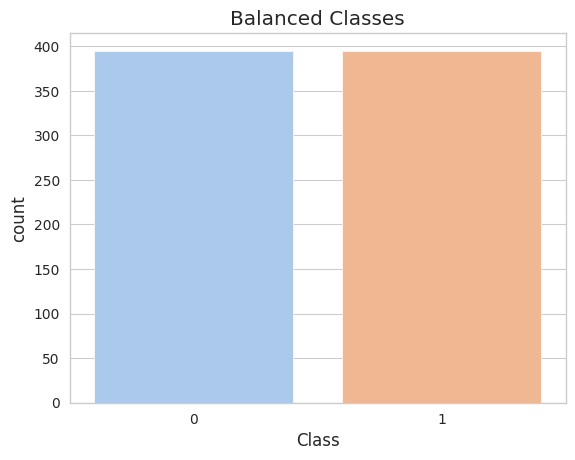

In [ ]:
sns.countplot(data=undersampling_balanced_train, x='Class')
plt.title('Balanced Classes')
plt.show()

E aproveitar para separar a nossa matriz de variáveis do vetor target

In [ ]:
undersample_X_train_balanced = undersampling_balanced_train.drop(columns=['Class'])
undersample_y_train_balanced = undersampling_balanced_train['Class']

##### **Aplicando SMOTE**:

Basicamente, o que o SMOTE faz é gerar novos exemplos da classe minoritária através de interpolação entre os pontos mais próximos. Podemos dizer que ao traçar linhas entre os vizinhos mais próximos de um datapoint de uma classe minoritária, podemos gerar novos datapoints "em cima" dessa linha, de modo que ele tenha características similares as observações originais, mas não seja uma cópia de alguma observação existente.

**Uma explicação mais aprofundada retirada do paper original que originou o método SMOTE a seguir:**

> We generate synthetic examples in a less application-specific manner, by
operating in “feature space” rather than “data space”. The minority class is  over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen. Our implementation currently uses five nearest neighbors. For instance, if the amount of over-sampling needed is 200%, only two neighbors from the five nearest neighbors are chosen and one sample is generated in the direction of each. Synthetic samples are generated in the following way: Take the difference between the feature vector (sample) under consideration and its nearest neighbor. Multiply this difference by a random number
between 0 and 1, and add it to the feature vector under consideration. This
causes the selection of a random point along the line segment between two specific features. This approach effectively forces the decision region of the minority class to become more general.

*Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2001). SMOTE: Synthetic Minority Over-sampling Technique. ArXiv. https://doi.org/10.1613/jair.953*

Pra aplicar essa técnica é fácil, basta chamarmos o método SMOTE() e passar a matriz de treino e o vetor de target do treino

In [ ]:
smote = SMOTE()
smote_X_train_balanced, smote_y_train_balanced = smote.fit_resample(X_train, y_train)

E agora podemos visualizar a nova distribuição

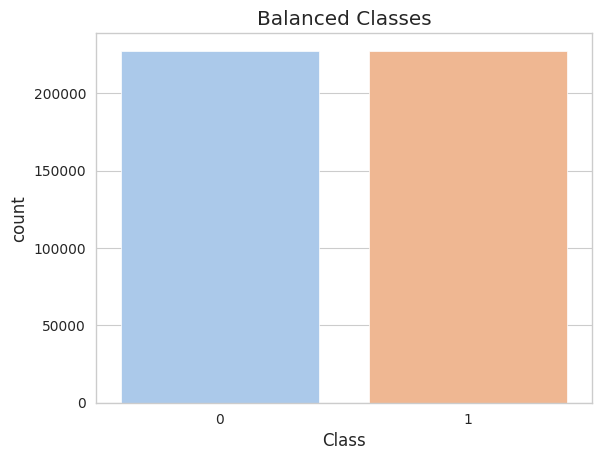

In [ ]:
sns.countplot(data=pd.concat([smote_X_train_balanced, smote_y_train_balanced], axis=1), x='Class')
plt.title('Balanced Classes')
plt.show()

#### 🔮 Utilizando o classificador Logistic Regression

In [ ]:
lg_clf1 = LogisticRegression(random_state=777)

#### 🏋️ Treinando...

In [ ]:
lg_clf1.fit(undersample_X_train_balanced, undersample_y_train_balanced)
y_pred_undersampling_lg = lg_clf1.predict(X_test)

#### 🤔 Analisando o Classification Report do modelo

In [ ]:
print('Classification Report With Undersampling (Logistic Regression):\n', classification_report(y_test,y_pred_undersampling_lg, digits=4))

Classification Report With Undersampling (Logistic Regression):
               precision    recall  f1-score   support

           0     0.9999    0.9678    0.9835     56865
           1     0.0463    0.9175    0.0882        97

    accuracy                         0.9677     56962
   macro avg     0.5231    0.9426    0.5359     56962
weighted avg     0.9982    0.9677    0.9820     56962



##### **Treinando novamente, mas com os dados balanceados pelo método SMOTE**

In [ ]:
lg_clf2 = LogisticRegression(random_state=777)
lg_clf2.fit(smote_X_train_balanced, smote_y_train_balanced)
y_pred_smote_lg = lg_clf2.predict(X_test)

#### 🤔 Analisando o Classification Report do modelo

In [ ]:
print('Classification Report With SMOTE (Logistic Regression):\n', classification_report(y_test,y_pred_smote_lg, digits=4))

Classification Report With SMOTE (Logistic Regression):
               precision    recall  f1-score   support

           0     0.9999    0.9746    0.9871     56865
           1     0.0587    0.9278    0.1104        97

    accuracy                         0.9745     56962
   macro avg     0.5293    0.9512    0.5487     56962
weighted avg     0.9983    0.9745    0.9856     56962



#### 🔮 Utilizando o classificador Random Forest

In [ ]:
rf_clf1 = RandomForestClassifier(random_state=777)

#### 🏋️ Treinando...

In [ ]:
rf_clf1.fit(undersample_X_train_balanced, undersample_y_train_balanced)
y_pred_undersampling = rf_clf1.predict(X_test)

In [ ]:
print('Classification Report With Undersampling (Random Forest):\n', classification_report(y_test,y_pred_undersampling, digits=4))

Classification Report With Undersampling (Random Forest):
               precision    recall  f1-score   support

           0     0.9998    0.9776    0.9886     56865
           1     0.0646    0.9072    0.1205        97

    accuracy                         0.9775     56962
   macro avg     0.5322    0.9424    0.5546     56962
weighted avg     0.9982    0.9775    0.9871     56962



In [ ]:
rf_clf2 = RandomForestClassifier(random_state=777)
rf_clf2.fit(smote_X_train_balanced, smote_y_train_balanced)
y_pred_smote = rf_clf2.predict(X_test)

In [ ]:
print('Classification Report With SMOTE (Random Forest):\n', classification_report(y_test,y_pred_smote, digits=4))

Classification Report With SMOTE (Random Forest):
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999     56865
           1     0.9444    0.8763    0.9091        97

    accuracy                         0.9997     56962
   macro avg     0.9721    0.9381    0.9545     56962
weighted avg     0.9997    0.9997    0.9997     56962



In [ ]:
cm = confusion_matrix(y_test, y_pred_smote, labels=rf_clf2.classes_, normalize='true')

In [ ]:
cm

array([[9.99912072e-01, 8.79275477e-05],
       [1.23711340e-01, 8.76288660e-01]])

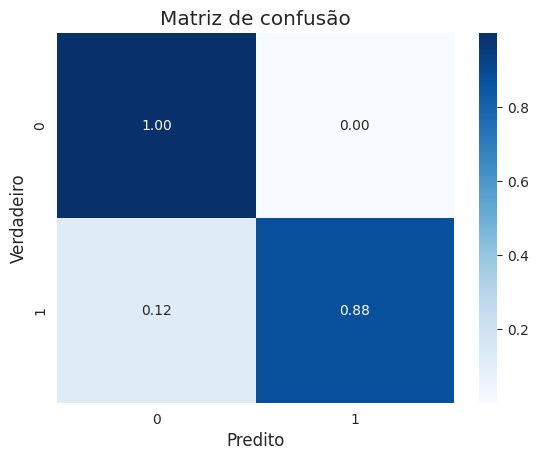

In [ ]:
ax= plt.subplot()

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")

ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_title('Matriz de confusão')
plt.show()

Podemos ver que conseguimos prever 88% dos casos em que haveria fraude na transação, isso com certeza já traria um grande ganho para empresa!

**Também podemos explorar mais uma métrica de avaliação: a curva ROC e a área abaixo da curva ROC.**

A curva ROC é um gráfico que mostra a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) para diferentes limiares de classificação. A área sob a curva ROC, conhecida como AUC, é uma métrica que mede a capacidade do modelo de distinguir entre classes positivas e negativas em diferentes limiares de classificação. Quanto maior o valor da AUC, melhor é o desempenho do modelo.

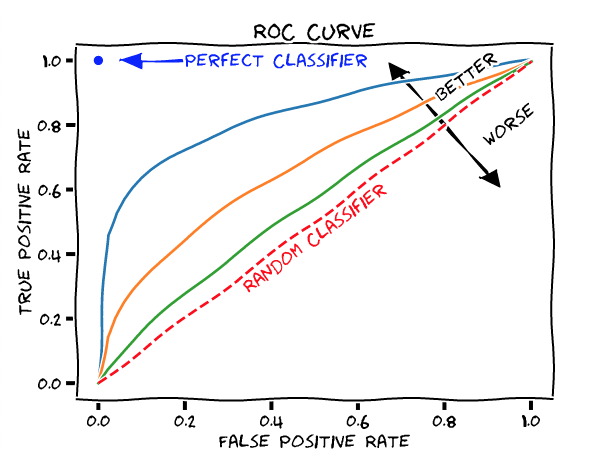

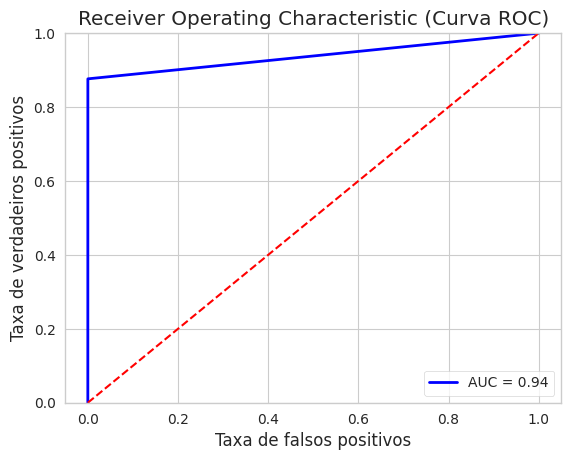

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_smote)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Curva ROC)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,  linewidth=2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('Taxa de verdadeiros positivos')
plt.xlabel('Taxa de falsos positivos')
plt.show()